## eda + prelim linear regression 
on acled and ucdp data

In [64]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV, MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import matplotlib as plt


In [170]:

acled_df = pd.read_csv('../data/acled/south_sudan.csv') 
## darfur: 9316 entries, 32 cols
# print(acled_df.info()) 
# print(acled_df.columns)
# acled_df['FATALITIES']


# ucdp_df = pd.read_csv("../data/ucdp/darfur_113023.csv").drop('low_est', axis=1) ## 1669 entries, 48 cols
# # print(ucdp_df.info()) 
# print(ucdp_df.columns)
# ucdp_df.dropna(inplace=True)
# ucdp_df

In [171]:
acled_df

,EVENT_ID_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,DISORDER_TYPE,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TAGS,TIMESTAMP
0,SSD9476,2023-09-29,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (South Sudan),Teachers (South Sudan),6,...,Bor,6.209,31.559,1,Eye Radio (South Sudan); Radio Tamazuj,National,"On 29 September 2023, more than 200 teachers s...",0,crowd size=more than 200,1696268002
1,SSD9474,2023-09-28,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Sudan),NaN,3,...,Bor,6.209,31.559,2,Eye Radio (South Sudan); Radio Tamazuj,National,"On 28 September 2023, unidentified gunmen atta...",2,NaN,1696268002
2,SSD9473,2023-09-27,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Sudan),NaN,3,...,Anyidi,6.180,31.811,2,Eye Radio (South Sudan),National,"On 27 September 2023, unidentified gunmen atta...",1,NaN,1696268002
3,SSD9468,2023-09-24,2023,2,Political violence,Violence against civilians,Abduction/forced disappearance,Military Forces of Uganda (1986-),NaN,8,...,Kajo-Keji,3.850,31.657,2,Radio Tamazuj,National,"Around 24 September 2023 (as reported), UPDF c...",0,NaN,1696268002
4,SSD9469,2023-09-24,2023,2,Political violence,Battles,Armed clash,Toposa Ethnic Militia (South Sudan),NaN,4,...,Nadapal,4.452,34.188,2,Radio Tamazuj,National,"Around 24 September 2023, Toposa Ethnic Militi...",0,NaN,1696268002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9221,SSD3,2011-07-16,2011,1,Political violence,Violence against civilians,Abduction/forced disappearance,LRA: Lords Resistance Army,NaN,2,...,Sopo,8.026,26.043,1,Resolve Crisis Initiative,Other,Two days after LRA forces abducted a man near ...,0,NaN,1633987184
9222,SSD2,2011-07-15,2011,3,Political violence,Battles,Armed clash,George Athor Deng Rebel Group,NaN,2,...,Pibor,6.798,33.131,1,Small Arms Survey,Other,"In June and July, forces loyal to Athor furthe...",0,NaN,1621903736
9223,SSD5830,2011-07-15,2011,1,Political violence,Violence against civilians,Attack,Murle Ethnic Militia (South Sudan),NaN,4,...,Kaikuiny,8.092,32.391,2,Aid Worker Security Database,Local partner-Other,"On 15 July 2011, Murle militia attacked an uns...",0,NaN,1659980428
9224,SSD1,2011-07-14,2011,1,Political violence,Violence against civilians,Abduction/forced disappearance,LRA: Lords Resistance Army,NaN,2,...,Deim Zubeir,7.715,26.195,1,Resolve Crisis Initiative,Other,LRA forces abducted a man from his fields outs...,0,NaN,1633987184


In [179]:
data = acled_df
X = data.drop('FATALITIES', axis=1)
y = data['FATALITIES']

# data = ucdp_df
# X = data.drop('best_est', axis=1)
# y = data['best_est']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create transformers for numeric and categorical features
## could use Imputer() from sklearn.preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with the preprocessor and a linear regression classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Ridge(alpha=2))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model (you can use appropriate metrics for your problem)
## 1 is the best, r^2 score
print("Model score: %.3f" % model.score(X_test, y_test))


Model score: 0.341


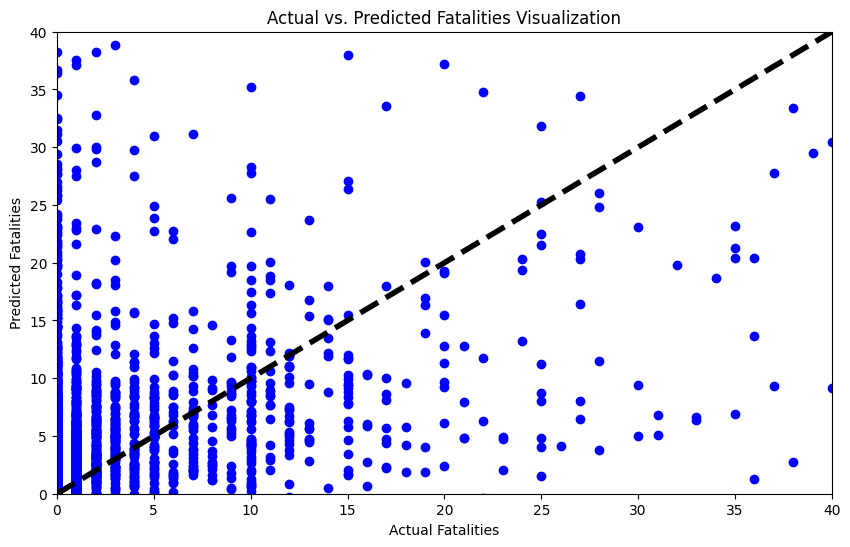

In [192]:
# Predict the values using the trained model
y_pred = model.predict(X_test)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')  # Plotting the actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Plotting a line for perfect predictions
plt.xlim(0, 40)  # Setting limit for x-axis
plt.ylim(0, 40)  # Setting limit for y-axis
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.title('Actual vs. Predicted Fatalities Visualization')
plt.show()

In [180]:
## evaluating the model 
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 314.4041162024616


In [181]:
from sklearn.metrics import r2_score

## the closer to 1 the better
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


R-squared: 0.34114177492100706


In [152]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge
param_grid = {'classifier__alpha': [0, 0.05, 0.1, 0.2, 1, 10]}  # Define the alpha values you want to test

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')  # cv is the number of folds for cross-validation

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate the best model
print("Best Model score: %.3f" % best_model.score(X_test, y_test))
print(f"Best alpha value: {best_model.named_steps['classifier'].alpha}")


Best Model score: 0.233
Best alpha value: 10


In [153]:
best = pd.DataFrame(grid_search.cv_results_)
best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.091854,0.005392,0.016234,0.000815,0,{'classifier__alpha': 0},0.070326,0.100108,0.049574,-0.609154,-0.051657,-0.088161,0.265443,6
1,0.089239,0.006120,0.016586,0.000675,0.05,{'classifier__alpha': 0.05},0.071620,0.100164,0.050300,-0.601663,-0.049235,-0.085763,0.262807,5
2,0.087318,0.005872,0.015923,0.000318,0.1,{'classifier__alpha': 0.1},0.072829,0.100210,0.051006,-0.594431,-0.046911,-0.083459,0.260257,4
3,0.083552,0.005357,0.015405,0.000407,0.2,{'classifier__alpha': 0.2},0.074946,0.100267,0.052340,-0.580684,-0.042550,-0.079136,0.255383,3
4,0.070775,0.004081,0.014927,0.000164,1,{'classifier__alpha': 1},0.084717,0.100042,0.060771,-0.497609,-0.016477,-0.053711,0.225539,2
5,0.049193,0.000359,0.014720,0.000133,10,{'classifier__alpha': 10},0.102640,0.096749,0.087248,-0.247968,0.055480,0.018830,0.134388,1


## raw results

on acled, darfur data:

test size: .2
- linear: LinearRegression()[0.1], Ridge() [0.147], Lasso()[0.052], ElasticNet()[0.05]
- trees: XGBRegressor()[0.25], RandomForestRegressor()[0.356, but takes a long time]
- neural network: MLPRegressor()[-5.803]
- also something called MultiTaskElasticNet() that doesn't work on sparse data 
- ElasticNetCV() does not run 

test size: .3
- LinearRegression() [0.304], Ridge() [0.300], Lasso and EN both [0.047]
- Ridge alpha CV: 0.01 best, basically Ridge << LinearRegression

     EVENT_ID_CNTY  EVENT_DATE  YEAR  TIME_PRECISION           DISORDER_TYPE  \
1183       SSD8158  2021-12-26  2021               1      Political violence   
1038       SSD8820  2022-02-18  2022               1      Political violence   
9215         SSD10  2011-08-19  2011               1      Political violence   
908        SSD8424  2022-04-07  2022               1      Political violence   
8490       SSD1281  2014-01-06  2014               1  Strategic developments   

                  EVENT_TYPE SUB_EVENT_TYPE  \
1183                 Battles    Armed clash   
1038                 Battles    Armed clash   
9215                 Battles    Armed clash   
908                  Battles    Armed clash   
8490  Strategic developments        Arrests   

                                                 ACTOR1  \
1183  SPLM-In Opposition: Sudan People's Liberation ...   
1038             Military Forces of South Sudan (2011-)   
9215                 Murle Ethnic Militia (South Sudan)   


IndexError: index 3 is out of bounds for axis 0 with size 2

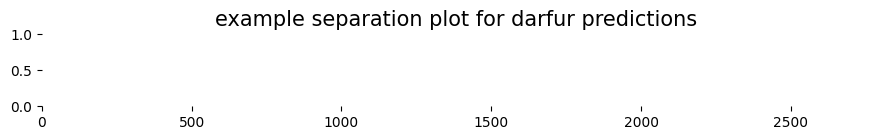

In [198]:
import sepplotlib as spl
## package documentation here: https://pypi.org/project/sepplotlib/
## originally by greenhill et al, a conflicts researcher

df = X_test.copy()
df['y_true'] = list(y_test.values)
df['y_pred'] = y_pred
print(df.head())

spl.SeparationPlot(
    df=df,
    y_true="y_true",
    y_pred="y_pred",
    title="example separation plot for darfur predictions"
)

In [195]:
## partial dependence plots

from sklearn.inspection import PartialDependenceDisplay
features = [0, 1, 2]
PartialDependenceDisplay.from_estimator(model, X_train, features, kind='both')



TypeError: can't multiply sequence by non-int of type 'float'